In [1]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
np.random.seed(1337)  # for reproducibility

from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10,mnist,fashion_mnist,cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import Tensor
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Layer,Flatten,BatchNormalization
from tensorflow.python.keras.engine.input_layer import InputLayer
from tensorflow.keras.constraints import max_norm,MinMaxNorm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
#tf.compat.v1.disable_eager_execution()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Run this cell if you want to use keras sergeon for complete removel of filters

In [33]:
#use while filter pruning via Keras-Sergeon
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly

! pip install tensorflow-gpu==2.0.0-beta1

In [2]:
def normalize(X_train,X_test):
  mean = np.mean(X_train,axis=(0,1,2,3))
  std = np.std(X_train, axis=(0, 1, 2, 3))
  print(mean)
  print(std)
  X_train = (X_train-mean)/(std+1e-7)
  X_test = (X_test-mean)/(std+1e-7)
  return X_train, X_test

In [3]:
#Data Processing
batch_size = 128
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = normalize(x_train, x_test)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
steps_per_epoch = x_train.shape[0]//batch_size

25.50944
70.18035
x_train shape: (60000, 32, 32, 1)
60000 train samples
10000 test samples


In [4]:
#Data Generator
batch_size = 128
maxepoches = 20
learning_rate = 0.01
lr_decay = 1e-6
lr_drop = 5


def lr_scheduler(epoch):
    if(epoch<250):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    else:
        return learning_rate * (0.4 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)


#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


In [5]:
#VGG-16
model = Sequential()
weight_decay = 0.005
x_shape = (32,32,1)

# model.add(UpSampling2D(size=(2, 2),input_shape=self.x_shape))
model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay),input_shape=x_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

In this step we will create a custom regularizer using "tf.keras.regularizers.Regularizer" which will apply waighted L1 regularization on pruning tensor vectors. The regularization would be waighted based on the size of pruning tensor vector size which will be passed through FPruningL layer.

In [7]:
#Beta Regularizer
class b_reg(tf.keras.regularizers.Regularizer):

    def __init__(self, b_scalef):
        self.b_scalef = K.cast_to_floatx(b_scalef)

    def __call__(self, weight_matrix):
      return K.sum(K.abs(weight_matrix)) * self.b_scalef

    def get_config(self): 
      return {'Factor': float(self.b_scalef)}


# Task 1

In this step we will create a custom tf layer for pruning tensor vectors. The layer will take size as initializing input and initialize a 1-D tensor of trainable weights from that size. These 1-D tensors will be initialized from ones and we will apply the above created regularization to push these tensors towards zero.
These custom layers will be placed as gates infront of all CONV layers. The input of these layers will be the output of CONV layers and the output of these layers would be a product of input wilth the 1-D tensor vector.

For this task you have to write the call function of FpruningL custom layer. call function is the function that will be called during runtime. The output of previous layer will be passed to this function as parameter(in this case 'x'), you have to return the product of 1-D tensor('kernel1') and previous layer output from this function. 

In [8]:
#Filter pruning lembda layer
class FPruningL(Layer):
    def __init__(self, size = 0.0, **kwargs):
        super(FPruningL, self).__init__(**kwargs)
        self.size = size
    def build(self, input_shape):
        self.kernel1 = self.add_weight(constraint=MinMaxNorm(min_value=0.0, max_value=1.0, rate=1.0, axis=0),
                                       name='kernel1', shape=( 1, 1, 1, self.size), 
                                       regularizer=b_reg(1/(self.size)), initializer='ones', trainable=True)
        super(FPruningL, self).build(input_shape) 
    def call(self, x):
        ############################## 
        # TASK 1 write your code here
        return tf.multiply(x, self.kernel1)
        ##############################
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        return {'num': self.num}

# Task 2

In this step we will create a new prunable network from the orignal netwok. We will place pruning custom layers infront of each CONV layer. To initialize custom layers we will pass the CONV layer filter number to these custom layers so that 1-D tensors of appropriate size can be initialized.

In this task you will create a new prunable model named 'model2' from the orignal model. you will create this new model by looping through the layer of orignal model. Add all the layers of the orignal model to the new model while conditioning on 'Conv2D'. For 'Conv2D' find the number of filters and add the 'Conv2D' layer to the network then initialize 'FPruningL' layer by passing number of filters(e.g: FPruningL(filters)) to it. Add this FPruningL layer to the network. Your prunable networkhouk like this:Cell below

Where CONV layer has a FPruningL infront of it

In [9]:
# creating pruneable model from orignal model
##############################
# TASK 2 write your code here
inp = Input(shape=(model.input_shape[1:]))
model2 = inp
for layer in model.layers:
  if (type(layer) == Conv2D):
    model2 = (layer)(model2)
    pruneLayer = FPruningL(layer.filters)
    model2 = (pruneLayer)(model2)
  else:
    model2 = (layer)(model2)
model2 = Model(inputs=[inp], outputs=model2)
##############################

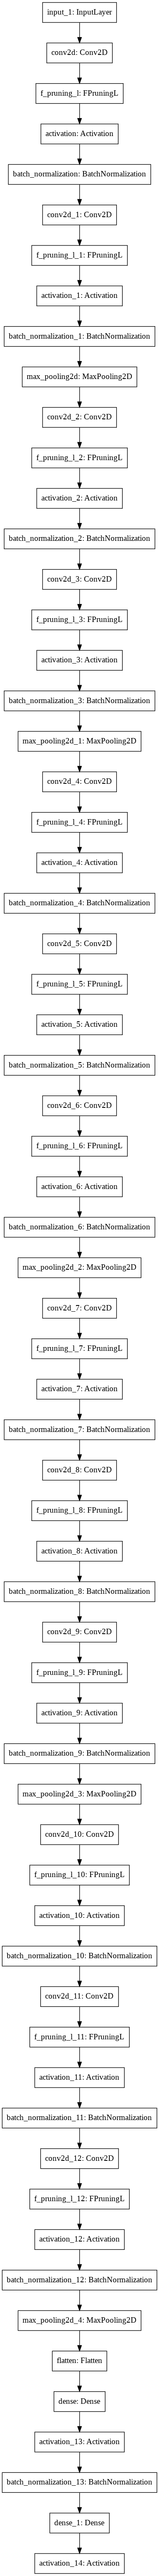

In [10]:
plot_model(model2)

We will create a callback function to monitor how many filters are dropable(i.e: there corrisponding pruning tensor value is below threash)

In [11]:
#Call back for Filter Drop info info
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    error = 0
    f = 0
    l = 0
    print('\n')
    for layer in model2.layers:
      if (type(layer)==FPruningL):
        w = layer.get_weights()
        f = np.count_nonzero(w[0] <= 0.005)
        l+=f
        print("Filters Dropable : ",f)
    print("Total Filters Dropable : ",l)

Compile and train prunable model.

In [12]:
sgd = SGD(lr=0.01, decay=lr_decay, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [13]:

# Fit the model on the batches generated by datagen.flow().
model2.fit(datagen.flow(x_train, y_train,
                                batch_size=batch_size),
                  steps_per_epoch=x_train.shape[0] // batch_size,
                  epochs=maxepoches,
                  validation_data=(x_test, y_test),callbacks=[MyCallback()],verbose=1)


Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
467/468 [============================>.] - ETA: 0s - loss: 28.7780 - accuracy: 0.8620

Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Total Filters Dropable :  0
468/468 [==============================] - 66s 141ms/step - loss: 28.7596 - accuracy: 0.8623 - val_loss: 28.0943 - val_accuracy: 0.0974
Epoch 2/20
467/468 [============================>.] - ETA: 0s - loss: 15.3371 - accuracy: 0.9497

Filters Dropable :  38
Filters Dropable :  25
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable :  0
Filters Dropable

# Task 3

In this step we will zero out pruning tensor values that are below thresh and turn all values above threash to 1 to completly shut down the respective filters of prunable values.

In this task you will loop through model2 and condition on FPruningL. You will get the weights of FPruningL layers, zero out pruning tensor values that are below thresh and turn all values above threash to 1 and set these updated weights to FPruningL layers. You will also make the FPruningL layers non-trainable.

Threashold is : 0.0005

Hint: see MyCallback().

In [14]:
# zero out scalling factor based on threashold
##############################
# TASK 3 Write your code here
error = 0
f = 0
l = 0
threshold = 0.0005
for layer in model2.layers:
  if (type(layer) == FPruningL):
    w = layer.get_weights()
    f += np.count_nonzero(w[0] <= threshold)
    w[0] = np.where(w[0] <= threshold, 0, w[0])
    w[0] = np.where(w[0] > threshold, 1, w[0])
    layer.set_weights(w)
    layer.trainable = False
print("Filters Dropped : ", f)
##############################

Filters Dropped :  3774


Till this step all of our prunable filters are theoratically pruned from the netwok but physically they are still a part of the network. To remove them physically run the notebook till end.

Now we will finetune this pruned network for a few epochs to reachive any drop in accuracy

In [15]:
sgd = SGD(lr=0.001, decay=lr_decay, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [16]:

# Fit the model on the batches generated by datagen.flow().
model2.fit(datagen.flow(x_train, y_train,
                                batch_size=batch_size),
                  steps_per_epoch=x_train.shape[0] // batch_size,
                  epochs=maxepoches,
                  validation_data=(x_test, y_test),callbacks=[MyCallback()],verbose=1)


Epoch 1/20
467/468 [============================>.] - ETA: 0s - loss: 1.7056 - accuracy: 0.9783

Filters Dropable :  60
Filters Dropable :  57
Filters Dropable :  116
Filters Dropable :  106
Filters Dropable :  221
Filters Dropable :  211
Filters Dropable :  207
Filters Dropable :  439
Filters Dropable :  451
Filters Dropable :  452
Filters Dropable :  485
Filters Dropable :  485
Filters Dropable :  484
Total Filters Dropable :  3774
468/468 [==============================] - 57s 122ms/step - loss: 1.7056 - accuracy: 0.9783 - val_loss: 1.6478 - val_accuracy: 0.9888
Epoch 2/20
467/468 [============================>.] - ETA: 0s - loss: 1.6592 - accuracy: 0.9837

Filters Dropable :  60
Filters Dropable :  57
Filters Dropable :  116
Filters Dropable :  106
Filters Dropable :  221
Filters Dropable :  211
Filters Dropable :  207
Filters Dropable :  439
Filters Dropable :  451
Filters Dropable :  452
Filters Dropable :  485
Filters Dropable :  485
Filters Dropable :  484
Total Filters Dropabl

Now we will remove our custom pruning layers from the network and save the pruning info from these layers in lists to use later for the removal of redundent filters.

In [17]:
#removing Pruning Layers
la = model2.layers
inputl = Input(shape=(model2.input_shape[1:]))
model3 = inputl

i = 0
while(i < len(la)):
  layer = la[i]
  if(type(layer)==Conv2D):
    c = layer
    if (type(la[i+1])==FPruningL):
      v = c.get_weights()
      v[0] = la[i+1].get_weights()[0]*v[0]
      c.set_weights(v)
      model3 = (c)(model3)

    else:
      model3 = (c)(model3)
  elif(type(layer)==InputLayer):
    print("")
  else:
    model3 = (layer)(model3)
    if(type(layer)==BatchNormalization):
      print("")
  i+=1
model3 = Model(inputs=[inputl], outputs=model3)

In [18]:
#removing BN to use keras sergeon for filter pruning
la = model3.layers
inputl = Input(shape=(model2.input_shape[1:]))
model4 = inputl
i = 0
w = []
b = []
while(i < len(la)):
  layer = la[i]
  if(type(layer)==FPruningL):
    w.append(layer.get_weights()[0][0][0][0])
  elif(type(layer)==InputLayer):
    print("")
  elif(type(layer)==BatchNormalization):
    b.append(layer.get_weights())
  else:
    model4 = (layer)(model4)
  i+=1
model4 = Model(inputs=[inputl], outputs=model4)

In [19]:
#BN heandling
wx = []
for i in range(0,len(w)):
  wx.append(w[i].astype(bool))

In [20]:
#BN heandling
for i in range(0,len(wx)):
  b[i][0]=b[i][0][wx[i]]
  b[i][1]=b[i][1][wx[i]]
  b[i][2]=b[i][2][wx[i]]
  b[i][3]=b[i][3][wx[i]]

In [21]:
#Filter pruning info handling
w2 = []
for i in range(0,len(w)):
  s = w[i].shape
  c = 0
  for j in range(0,s[0]):
    if(w[i][j]==0):
      c+=1
  k = np.zeros(c)
  l = 0
  for j in range(0,s[0]):
    if(w[i][j]==0):
      k[l]=j
      l+=1
  w2.append(k)

In [22]:
!pip install tfkerassurgeon

In [23]:
from tfkerassurgeon.surgeon import Surgeon

In [24]:
surgeon = Surgeon(model4, None)
i = 0
for layer in model4.layers:
  if(type(layer)==Conv2D):
    w2[i] = w2[i].astype(int)
    s = w2[i].shape
    if(s[0]!=0):  
      surgeon.add_job('delete_channels', layer, node_indexes=None, channels=w2[i])
    i+=1

In [25]:
new_model = surgeon.operate()

Deleting 60/64 channels from layer: conv2d
Deleting 57/64 channels from layer: conv2d_1
Deleting 116/128 channels from layer: conv2d_2
Deleting 106/128 channels from layer: conv2d_3
Deleting 221/256 channels from layer: conv2d_4
Deleting 211/256 channels from layer: conv2d_5
Deleting 207/256 channels from layer: conv2d_6
Deleting 439/512 channels from layer: conv2d_7
Deleting 451/512 channels from layer: conv2d_8
Deleting 452/512 channels from layer: conv2d_9
Deleting 485/512 channels from layer: conv2d_10
Deleting 485/512 channels from layer: conv2d_11
Deleting 484/512 channels from layer: conv2d_12


In [26]:
#readding BN
la = model3.layers
inputl = Input(shape=(model2.input_shape[1:]))
model5 = inputl
i = 0
for layer in new_model.layers:
  if(type(layer)==Activation and i<len(b)):
    model5 = (layer)(model5)
    model5 = (BatchNormalization())(model5)
    i+=1
  else:
    model5 = (layer)(model5)
model5 = Model(inputs=[inputl], outputs=model5)

In [27]:
#Adding weights to BN
i = 0
for layer in model5.layers:
  if(type(layer)==BatchNormalization):
    layer.set_weights(b[i])
    i+=1

In [28]:
def count_conv_params_flops(conv_layer, verbose=0):
    # out shape is  n_cells_dim1 * (n_cells_dim2 * n_cells_dim3)
    out_shape = conv_layer.output.shape.as_list()
    n_cells_total = np.prod(out_shape[1:-1])

    n_conv_params_total = conv_layer.count_params()

    conv_flops = 2 * n_conv_params_total * n_cells_total

    if verbose:
        print("layer %s params: %s" % (conv_layer.name, "{:,}".format(n_conv_params_total)))
        print("layer %s flops: %s" % (conv_layer.name, "{:,}".format(conv_flops)))

    return n_conv_params_total, conv_flops


def count_dense_params_flops(dense_layer, verbose=0):
    # out shape is  n_cells_dim1 * (n_cells_dim2 * n_cells_dim3)
    out_shape = dense_layer.output.shape.as_list()
    n_cells_total = np.prod(out_shape[1:-1])

    n_dense_params_total = dense_layer.count_params()

    dense_flops = 2 * n_dense_params_total

    if verbose:
        print("layer %s params: %s" % (dense_layer.name, "{:,}".format(n_dense_params_total)))
        print("layer %s flops: %s" % (dense_layer.name, "{:,}".format(dense_flops)))

    return n_dense_params_total, dense_flops


def count_model_params_flops(model):
    total_params = 0
    total_flops = 0

    model_layers = model.layers

    for layer in model_layers:

        if any(conv_type in str(type(layer)) for conv_type in ['Conv1D', 'Conv2D', 'Conv3D']):
            params, flops = count_conv_params_flops(layer)
            total_params += params
            total_flops += flops
        elif 'Dense' in str(type(layer)):
            params, flops = count_dense_params_flops(layer)
            total_params += params
            total_flops += flops
        # else:
        #     print("warning:: skippring layer: %s" % str(layer))

    print("total params (%s) : %s" % (model.name, "{:,}".format(total_params)))
    print("total flops  (%s) : %s" % (model.name, "{:,}".format(total_flops)))

    return total_params, total_flops

In [29]:
count_model_params_flops(model)

total params (sequential) : 14,981,322
total flops  (sequential) : 625,122,324


(14981322, 625122324)

In [30]:
count_model_params_flops(model5)

total params (model_4) : 197,953
total flops  (model_4) : 11,128,556


(197953, 11128556)

In [31]:
sgd = SGD(lr=0.001, decay=lr_decay, momentum=0.9, nesterov=True)
model5.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [32]:

# Fit the model on the batches generated by datagen.flow().
model5.fit(datagen.flow(x_train, y_train,
                                batch_size=batch_size),
                  steps_per_epoch=x_train.shape[0] // batch_size,
                  epochs=maxepoches,
                  validation_data=(x_test, y_test),callbacks=[MyCallback()],verbose=1)


Epoch 1/20
467/468 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9853

Filters Dropable :  60
Filters Dropable :  57
Filters Dropable :  116
Filters Dropable :  106
Filters Dropable :  221
Filters Dropable :  211
Filters Dropable :  207
Filters Dropable :  439
Filters Dropable :  451
Filters Dropable :  452
Filters Dropable :  485
Filters Dropable :  485
Filters Dropable :  484
Total Filters Dropable :  3774
468/468 [==============================] - 36s 76ms/step - loss: 0.0859 - accuracy: 0.9853 - val_loss: 0.0796 - val_accuracy: 0.9877
Epoch 2/20
467/468 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9852

Filters Dropable :  60
Filters Dropable :  57
Filters Dropable :  116
Filters Dropable :  106
Filters Dropable :  221
Filters Dropable :  211
Filters Dropable :  207
Filters Dropable :  439
Filters Dropable :  451
Filters Dropable :  452
Filters Dropable :  485
Filters Dropable :  485
Filters Dropable :  484
Total Filters Dropable